Imports

In [198]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
from scipy import stats
from scipy.stats import levene
from matplotlib.ticker import LogLocator, LogFormatter
import csv
from scipy.stats import ttest_ind

Plotting function

In [8]:
def plot_price_development(price_histories, window=50):
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(price_histories):
        moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
        plt.plot(range(len(moving_avg)), moving_avg, label=f'Firm {i+1}')
    plt.xlabel("Iterations")
    plt.ylabel("Price Moving Average")
    plt.title("Price Development Over Time (Moving Average)")
    plt.legend()
    plt.show()

Baseline algorithm

In [177]:
class Firm_N:
    def __init__(self, mc, price_floor, price_cap, learning_rate=0.85, discount_factor=0.98):
        self.mc = mc
        self.price_floor = price_floor
        self.price_cap = price_cap
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = {}

    def get_state(self, prices):
        return tuple(int(p) for p in prices)  # Keep states as whole numbers

    def get_action(self, state, prices, firm_index):
        if state not in self.q_table:
            self.q_table[state] = {0: 0, 1: 0, 2: 0}  # Actions: 0 (decrease), 1 (same), 2 (increase)

        # Find the minimum price among competitors (exclude own price)
        competitor_prices = prices[:firm_index] + prices[firm_index+1:]  # Excludes current firm's price
        min_competitor_price = min(competitor_prices)

        # Check if the firm's price is at least 2 below the minimum competitor price
        if prices[firm_index] <= min_competitor_price - 2:
            # Apply exploration rate, but limit to actions 1 (same) or 2 (increase)
            if np.random.rand() < 0.5:  # Exploration rate
                return np.random.choice([1, 2])
            else:
                return max({k: v for k, v in self.q_table[state].items() if k in [1, 2]}, key=self.q_table[state].get)

        # Regular exploration-exploitation logic
        if np.random.rand() < 0.5:  # Exploration rate
            return np.random.choice([0, 1, 2])
        else:
            return max(self.q_table[state], key=self.q_table[state].get)

    def get_learned_policy(self):
        policy = {}
        for state, actions in self.q_table.items():
            best_action = max(actions, key=actions.get)
            policy[state] = best_action
        return policy

    def update_q_value(self, state, action, reward, next_state):
        if next_state not in self.q_table:
            self.q_table[next_state] = {0: 0, 1: 0, 2: 0}
        best_next_action = max(self.q_table[next_state], key=self.q_table[next_state].get)

        self.q_table[state][action] += self.learning_rate * (
            reward + self.discount_factor * self.q_table[next_state][best_next_action] - self.q_table[state][action]
        )

    def calculate_profit(self, price, min_price_n):
        return (100 - price) * (price - 10) / min_price_n


def simulate_bertrand_rl(n_players=2, max_iterations=500000, price_floor=10, price_cap=55, start_prices=10):
    firms = [Firm_N(mc=10, price_floor=price_floor, price_cap=price_cap) for _ in range(n_players)]

    if isinstance(start_prices, (int, float)):
        prices = [start_prices] * n_players
    elif isinstance(start_prices, list):
        if len(start_prices) != n_players:
            raise ValueError("Length of start_prices must match n_players")
        prices = start_prices
    else:
        raise ValueError("start_prices must be an int, float, or list of length n_players")

    price_histories = [[p] for p in prices]
    rewards = [[] for _ in range(n_players)]
    Final_policy =[]

    for _ in range(max_iterations):
        states = [firm.get_state(prices) for firm in firms]
        actions = [firm.get_action(state, prices, j) for j, (firm, state) in enumerate(zip(firms, states))]

        # Determine new prices
        new_prices = []
        for j, (firm, action) in enumerate(zip(firms, actions)):
            if action == 0:  # Decrease price
                new_price = max(prices[j] - 1, price_floor)
            elif action == 2:  # Increase price
                new_price = min(prices[j] + 1, price_cap)
            else:
                new_price = prices[j]
            new_prices.append(new_price)

        # Find the minimum price and the number of firms setting it
        min_price = min(new_prices)
        min_price_n = new_prices.count(min_price)

        # Compute profit ONCE (only firms with min_price get this)
        profit_value = (100 - min_price) * (min_price - 10) / min_price_n

        # Assign profits (only firms setting min_price receive profit_value)
        profits = [profit_value if new_prices[j] == min_price else 0 for j in range(n_players)]

        # Update Q-values
        for j, firm in enumerate(firms):
            next_state = firm.get_state(new_prices)
            firm.update_q_value(states[j], actions[j], profits[j], next_state)

        # Store results
        for j in range(n_players):
            price_histories[j].append(new_prices[j])
            rewards[j].append(profits[j])

        prices = new_prices
        

    for firm in firms:
        Final_policy.append(firm.get_learned_policy())

    return price_histories, Final_policy

In [18]:
prices, Final_Policy = simulate_bertrand_rl(n_players=2, max_iterations= 500000, price_floor=10, price_cap=55, start_prices=10)
#plot_price_development(prices, window = 1000)

Plot baseline findings

In [ ]:
window_size = 1000
moving_avg_A = pd.Series(prices[0]).rolling(window=window_size).mean()
moving_avg_B = pd.Series(prices[1]).rolling(window=window_size).mean()

# Define figure and subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# Firm A Plot
ax1.plot(moving_avg_A, label='Firm A Moving Average', color='#1f77b4', linewidth=2, alpha=0.8)
ax1.axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 10)')
ax1.axhline(y=55, color='blue', linestyle='-', linewidth=1.5, label='Monopoly Price (p = 55)')
ax1.set_xlabel('Iterations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price', fontsize=14, fontweight='bold')
ax1.set_title('Price Evolution of Firm A Over Time', fontsize=16, fontweight='bold', pad=20)
ax1.ticklabel_format(style='plain', axis='x')
ax1.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1)
ax1.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0
# Firm B Plot
ax2.plot(moving_avg_B, label='Firm B Moving Average', color='#ff7f0e', linewidth=2, alpha=0.8)
ax2.axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 10)')
ax2.axhline(y=55, color='blue', linestyle='-', linewidth=1.5, label='Monopoly Price (p = 55)')
ax2.set_xlabel('Iterations', fontsize=14, fontweight='bold')
ax2.set_title('Price Evolution of Firm B Over Time', fontsize=16, fontweight='bold', pad=20)
ax2.ticklabel_format(style='plain', axis='x')
ax2.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1)
ax2.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0
# Save the figure
plt.tight_layout()
plt.savefig('NEW_baseline_findings.png', format='png', dpi=300)
plt.show()



Generate visualisation of final stratagies

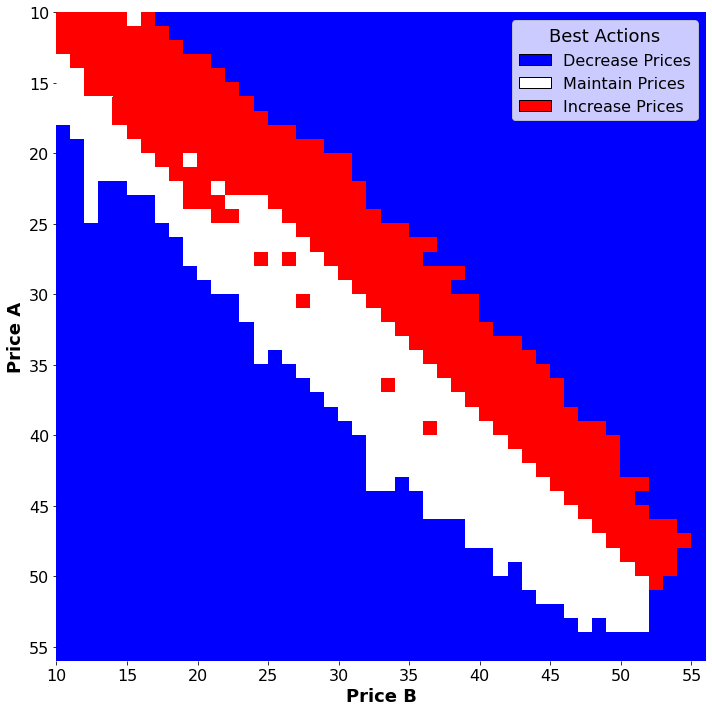

In [160]:
'''
def simulate_multiple_runs(runs):
    aggregated_policy = {}
    final_prices = []
    
    for i in range(runs):
        # Simulate one run
        prices, Final_Policy = simulate_bertrand_rl(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)

        if isinstance(Final_Policy, list) and len(Final_Policy) > 0:
            policy_A = Final_Policy[0]  # Extract Firm A's policy
        else:
            raise ValueError("Final_Policy does not contain expected values.")
        
        final_prices.append(prices[0][-1])  # Last price of Firm A
        
        # Aggregate actions
        for state, action in policy_A.items():
            if state not in aggregated_policy:
                aggregated_policy[state] = {0: 0, 1: 0, 2: 0}
            aggregated_policy[state][action] += 1
        if (i+1) % 10 == 0:
            print(i+1)
    return aggregated_policy, final_prices

aggregated_policy, final_prices = simulate_multiple_runs(runs=50)

df = pd.DataFrame(final_prices, columns=["Final Price"])

# Save to CSV
df.to_csv("New_final_prices.csv", index=False)

# Determine state dimensions dynamically for the heatmap
'''
states_A = list(aggregated_policy.keys())
Price_A2 = [state[0] for state in states_A]
Price_B2 = [state[1] for state in states_A]

# Define matrix size based on the range of prices (10 to 55)
min_price = 10
max_price = 55

# Matrix size will reflect the range from 10 to 55 (inclusive)
matrix_size_A = max_price - min_price + 1
matrix_size_B = max_price - min_price + 1

# Create a matrix to map the most frequent actions (initialize with -1 for no action)
policy_matrix = np.full((matrix_size_A, matrix_size_B), -1)

# Populate the matrix with the most frequent actions
for state, action_counts in aggregated_policy.items():
    quantity_A, quantity_B = state[:2]  # Extract the quantities (prices)
    
    # Determine the most frequent action for this state
    most_frequent_action = max(action_counts, key=action_counts.get)
    
    # Adjust indices based on start_value (if you want to shift the range)
    adj_quantity_A = quantity_A - min_price  # Adjust by 10
    adj_quantity_B = quantity_B - min_price  # Adjust by 10

    # Store the most frequent action in the policy_matrix
    policy_matrix[adj_quantity_A][adj_quantity_B] = most_frequent_action

# Create a custom colormap for discrete values (-1, 0, 1)
custom_cmap = ListedColormap(['blue', 'white', 'red'])

# Plot the heatmap with the custom colormap
plt.figure(figsize=(10, 10))
sns.heatmap(
    policy_matrix,
    cmap=custom_cmap,
    cbar=False,
    xticklabels=[f"{x + min_price}" for x in range(matrix_size_B)],
    yticklabels=[f"{y + min_price}" for y in range(matrix_size_A)],
    vmin=-1, vmax=2  # Set range to include all actions (-1, 0, 1)
)

plt.xlabel("Price B", fontsize=18, fontweight='bold')
plt.ylabel("Price A", fontsize=18, fontweight='bold')

xticks = np.arange(min_price, max_price + 1, 5)
yticks = np.arange(min_price, max_price + 1, 5)

plt.xticks(xticks - min_price, xticks, fontsize=16, rotation=0)  # Adjust x-axis labels and font size
plt.yticks(yticks - min_price, yticks, fontsize=16)  #

# Add a custom legend with explicit colors for each action
legend_elements = [
    Patch(facecolor="blue", edgecolor="black", label="Decrease Prices"),
    Patch(facecolor="white", edgecolor="black", label="Maintain Prices"),
    Patch(facecolor="red", edgecolor="black", label="Increase Prices"),
]

plt.legend(
    handles=legend_elements,
    loc="upper right",
    title="Best Actions",
    fontsize=16,
    title_fontsize=18,
    frameon=True,
    fancybox=True
)

plt.tight_layout()
plt.savefig('NEWHeatmap.png', format='png', dpi=300)
plt.show()

Statistical analysis of baseline model

In [51]:
final_price = df["Final Price"]
# T-test comparison to 10
t_stat_10, p_value_10 = stats.ttest_1samp(final_price, 10)

# T-test comparison to 55
t_stat_55, p_value_55 = stats.ttest_1samp(final_price, 55)

mean_price = final_price.mean()
std_price = final_price.std()
n = len(final_price)

# Confidence Interval for different significance levels
alpha_95 = 0.05  # 95% significance level
alpha_99 = 0.01  # 99% significance level
alpha_999 = 0.001  # 99.9% significance level

# Function to calculate CI and t-statistics
def calculate_ci_and_t(alpha, mean_price, std_price, n, comparison_value):
    t_critical = stats.t.ppf(1 - alpha / 2, df=n - 1)
    margin_of_error = t_critical * (std_price / np.sqrt(n))
    ci_lower = mean_price - margin_of_error
    ci_upper = mean_price + margin_of_error
    t_stat, p_value = stats.ttest_1samp(final_price, comparison_value)
    return ci_lower, ci_upper, t_stat, p_value

# Calculate CI for different significance levels
ci_95_lower, ci_95_upper, t_stat_95, p_value_95 = calculate_ci_and_t(alpha_95, mean_price, std_price, n, 10)
ci_99_lower, ci_99_upper, t_stat_99, p_value_99 = calculate_ci_and_t(alpha_99, mean_price, std_price, n, 10)
ci_999_lower, ci_999_upper, t_stat_999, p_value_999 = calculate_ci_and_t(alpha_999, mean_price, std_price, n, 10)

# Latex table for confidence intervals at different significance levels
latex_table = f"""
\\begin{{table}}[h!]
\\centering
\\begin{{tabular}}{{|c|c|c|c|}}
\\hline
Significance Level & CI Lower Bound & CI Upper Bound & T-statistic \\\\
\\hline
95\% & {ci_95_lower:.4f} & {ci_95_upper:.4f} & {t_stat_95:.4f} \\\\
99\% & {ci_99_lower:.4f} & {ci_99_upper:.4f} & {t_stat_99:.4f} \\\\
99.9\% & {ci_999_lower:.4f} & {ci_999_upper:.4f} & {t_stat_999:.4f} \\\\
\\hline
\\end{{tabular}}
\\caption{{Confidence Intervals and T-statistics comparing the final price to 10}}
\\end{{table}}
"""

# Latex table for t-values comparing to 55
latex_table_55 = f"""
\\begin{{table}}[h!]
\\centering
\\begin{{tabular}}{{|c|c|c|}}
\\hline
Comparison Value & T-statistic & P-value \\\\
\\hline
10 & {t_stat_10:.4f} & {p_value_10:.4f} \\\\
55 & {t_stat_55:.4f} & {p_value_55:.4f} \\\\
\\hline
\\end{{tabular}}
\\caption{{T-statistics comparing the final price to 10 and 55}}
\\end{{table}}
"""

# Output latex tables
print(latex_table)
print(latex_table_55)
print(mean_price)

,Final Price
0,31
1,37
2,40
3,31
4,31
5,41
6,33
7,38
8,36
9,33



\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Significance Level & CI Lower Bound & CI Upper Bound & T-statistic \\
\hline
95\% & 33.1939 & 36.0461 & 34.6938 \\
99\% & 32.7182 & 36.5218 & 34.6938 \\
99.9\% & 32.1360 & 37.1040 & 34.6938 \\
\hline
\end{tabular}
\caption{Confidence Intervals and T-statistics comparing the final price to 10}
\end{table}


\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Comparison Value & T-statistic & P-value \\
\hline
10 & 34.6938 & 0.0000 \\
55 & -28.7189 & 0.0000 \\
\hline
\end{tabular}
\caption{T-statistics comparing the final price to 10 and 55}
\end{table}

34.62


       Firm  Iteration  Drop Start Price  Severity  Punishment Duration  \
0    Firm 1          5                11         1                    1   
1    Firm 1          7                11         1                    7   
2    Firm 1         15                11         1                    4   
3    Firm 1         22                12         2                   12   
4    Firm 1         35                12         2                   24   
..      ...        ...               ...       ...                  ...   
292  Firm 2     387592                50         1                    1   
293  Firm 2     387594                50        26                 8689   
294  Firm 2     396285                51        30                29719   
295  Firm 2     426005                51        31                57823   
296  Firm 2     483829                51        20                 3742   

     Periods to Restore  
0                     1  
1                     7  
2                    

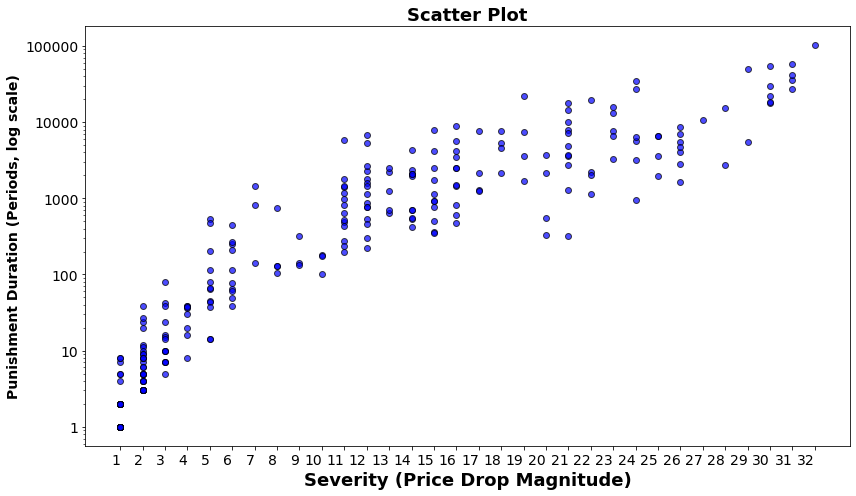

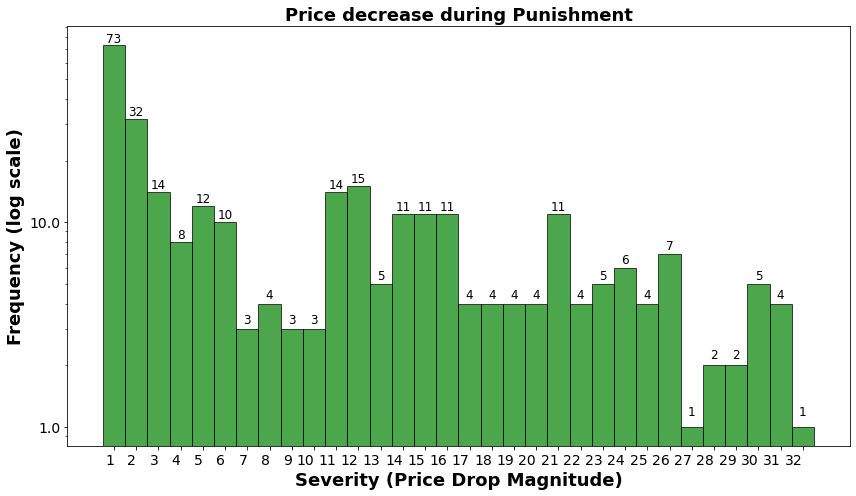

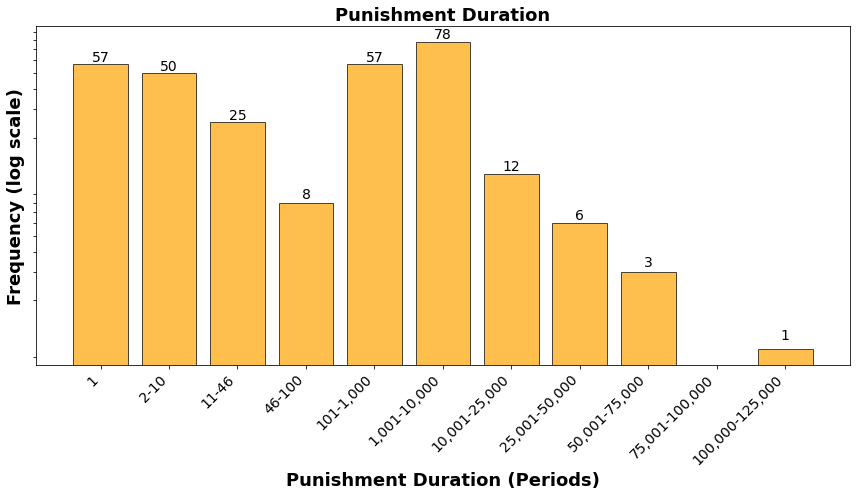

In [60]:
punishment_data = []

# Iterate over firms and their price histories
for firm_id, price_history in enumerate(prices):
    last_price = price_history[0]
    drop_detected = False
    drop_start_index = 0
    drop_start_price = last_price
    lowest_price = last_price

    for i in range(1, len(price_history)):
        current_price = price_history[i]
        
        # Detect start of a price drop
        if not drop_detected and current_price < last_price:
            drop_detected = True
            drop_start_price = last_price
            drop_start_index = i
            lowest_price = current_price

        elif drop_detected:
            # Track the lowest price during the drop
            lowest_price = min(lowest_price, current_price)

            # Detect restoration to the original price
            if current_price >= drop_start_price:
                duration = i - drop_start_index  # Duration of the drop
                magnitude = drop_start_price - lowest_price  # Magnitude of the drop
                punishment_data.append({
                    'Firm': f'Firm {firm_id + 1}',  # Correctly label the firm (starting from 1)
                    'Iteration': drop_start_index,  # Iteration when the drop started
                    'Drop Start Price': drop_start_price,
                    'Severity': drop_start_price - lowest_price,
                    'Punishment Duration': duration,
                    'Periods to Restore': duration  # Same as punishment duration in this case
                })
                drop_detected = False

        last_price = current_price

# Create a DataFrame from the punishment data
punishment_df = pd.DataFrame(punishment_data)

# Save to a CSV file
punishment_df.to_csv('NEW_punishment_data.csv', index=False)

# Display the DataFrame
print(punishment_df)

print(max(punishment_df['Punishment Duration']))

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Scatter plot (Figure 1)
fig1 = plt.figure(figsize=(12, 7))
ax1 = fig1.add_subplot(111)
ax1.scatter(punishment_df['Severity'], punishment_df['Punishment Duration'], color='blue', edgecolors='black', alpha=0.7)
ax1.set_xlabel("Severity (Price Drop Magnitude)", fontweight='bold', fontsize=18)
ax1.set_ylabel("Punishment Duration (Periods, log scale)", fontweight='bold', fontsize=14)
ax1.set_yscale('log')
ax1.set_title("Scatter Plot", fontsize=18, fontweight='bold')

# Customize y-axis tick labels to show normal numbers
formatter = mticker.ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)

ax1.set_xticks(range(int(min(punishment_df['Severity'])), int(max(punishment_df['Severity'])) + 1, 1))
ax1.set_xticklabels(ax1.get_xticks(), ha='right', fontsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig("NEWpunishment_1.png")
plt.show()

# Histogram for Severity (Figure 2)
fig2 = plt.figure(figsize=(12, 7))
ax2 = fig2.add_subplot(111)
counts, bins, patches = ax2.hist(punishment_df['Severity'], bins=max(punishment_df['Severity']), color='green', edgecolor='black', alpha=0.7)
ax2.set_xlabel("Severity (Price Drop Magnitude)", fontweight='bold', fontsize=18)
ax2.set_ylabel("Frequency (log scale)", fontweight='bold', fontsize=18)
ax2.set_yscale('log')
ax2.set_title("Price decrease during Punishment", fontsize=18, fontweight='bold')
ax2.yaxis.set_major_formatter(formatter)

# Add counts on top of bars
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        ax2.text(bin_edge + (bins[1] - bins[0]) / 2, count + 0.1, f"{int(count)}", ha='center', va='bottom', fontsize=12)

# Set custom x-ticks to show bin ranges
bin_ranges = [f"{int(bins[i+1])}" for i in range(len(bins)-1)]
ax2.set_xticks(bins[:-1] + (bins[1] - bins[0]) / 2)  # Set the position of ticks in the middle of each bin
ax2.set_xticklabels(bin_ranges, ha='right', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig("NEWpunishment_2.png")
plt.show()

# Histogram for Punishment Duration (Figure 3)
fig3 = plt.figure(figsize=(12, 7))

# Manually binning the data
bins_custom = [0, 2, 11, 46, 100, 1000, 10000, 25000, 50000, 75000, 100000, 125000]
bin_labels = ["1", "2-10", "11-46", "46-100", "101-1,000", "1,001-10,000", "10,001-25,000", "25,001-50,000", "50,001-75,000", "75,001-100,000", "100,000-125,000"]

# Binned counts
binned_counts = []
for i in range(len(bins_custom)-1):
    bin_start, bin_end = bins_custom[i], bins_custom[i+1]
    count = np.sum((punishment_df['Punishment Duration'] >= bin_start) & (punishment_df['Punishment Duration'] < bin_end))
    binned_counts.append(count)

ax3 = fig3.add_subplot(111)
ax3.bar(bin_labels, binned_counts, color='orange', edgecolor='black', alpha=0.7)

# Customize x-axis labels
ax3.set_xticks(range(len(bin_labels)))  # Set the tick positions to match bin labels
ax3.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=14)

# Set the y-axis scale to log
ax3.set_yscale('log')

# Set labels and title
ax3.set_xlabel("Punishment Duration (Periods)", fontweight='bold', fontsize=18)
ax3.set_ylabel("Frequency (log scale)", fontweight='bold', fontsize=18)
ax3.set_title("Punishment Duration", fontsize=18, fontweight='bold')

# Customize y-axis
ax3.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))  # Automatically choose log ticks
ax3.yaxis.set_major_formatter(LogFormatter(base=10.0))  # Format y-axis labels in log scale

ax3.tick_params(axis='y', labelsize=14)

# Add counts on top of bars
for i, count in enumerate(binned_counts):
    if count > 0:
        ax3.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.savefig("NEWpunishment_3.png")
plt.show()

Price war detector

In [188]:
def analyze_price_wars(price_histories):
    n_firms = len(price_histories)
    price_wars = []
    active_war = False  # Ensure only one punishment period at a time
    war_start_iteration = None
    war_initiator = None
    initial_price = None
    max_price_drop = None
    simultaneous_war_active = False 
    simultaneous_war_count = 0
    for t in range(1, len(price_histories[0])):  # Iterate over time steps
        # Extract prices at current and previous iteration
        prev_prices = [price_histories[i][t - 1] for i in range(n_firms)]
        curr_prices = [price_histories[i][t] for i in range(n_firms)]

        # Identify firms that decreased their price
        price_drops = [curr_prices[i] < prev_prices[i] for i in range(n_firms)]
        firms_lowered = [i for i, dropped in enumerate(price_drops) if dropped]

        # Start tracking a price war if exactly **one** firm lowers its price
        if not active_war and len(firms_lowered) == 1:
            active_war = True
            war_start_iteration = t
            war_initiator = firms_lowered[0]
            initial_price = prev_prices[war_initiator]
            max_price_drop = initial_price - curr_prices[war_initiator]
        
        if len(firms_lowered) == n_firms:  # If all firms lower prices in the same round
            if not simultaneous_war_active:
                simultaneous_war_active = True
                simultaneous_war_count += 1  # Count this as a new event
        else:
            simultaneous_war_active = False 
            
        # Update max price drop while the war is ongoing
        if active_war:
            max_price_drop = max(max_price_drop, initial_price - min(curr_prices))

        # End tracking when all firms return to at least the original price
        if active_war and all(p >= initial_price for p in curr_prices):
            war_duration = t - war_start_iteration
            price_wars.append({
                "Firm Initiated": war_initiator,
                "Iterations Until Recovery": war_duration,
                "Starting Price": initial_price,
                "Price Drop": max_price_drop,
                "Restoration Iteration": t
            })
            active_war = False  # Reset war tracking

    # Convert results into a DataFrame
    df_price_wars = pd.DataFrame(price_wars)
    return df_price_wars, simultaneous_war_count

    price_histories, _ = simulate_bertrand_rl(n_players=2, max_iterations=500000, start_prices=10, price_cap=55, price_floor=10)
    df_results, sim_war_count = analyze_price_wars(price_histories)
print(df_results)
print(len(df_results["Starting Price"]))
print(sim_war_count)

    Firm Initiated  Iterations Until Recovery  Starting Price  Price Drop  \
0                0                         13              11           1   
1                1                         13              12           2   
2                1                        957              15           5   
3                0                         16              15           4   
4                1                       1244              16           6   
..             ...                        ...             ...         ...   
62               1                     143273              49          30   
63               1                      56171              51          29   
64               1                          1              51           1   
65               0                          3              51           2   
66               1                       7916              52          25   

    Restoration Iteration  
0                      16  
1                  

Price war data collection

In [189]:
# Number of simulations to run
num_simulations = 50
n_players = 2
max_iterations = 500000
start_prices = 10

# Data storage
all_price_wars = []
simultaneous_war_counts = []

for i in range(num_simulations):
    # Run simulation
    price_histories, _ = simulate_bertrand_rl(n_players=n_players, max_iterations=max_iterations, start_prices=start_prices)
    
    # Analyze price wars
    df_wars, simultaneous_wars = analyze_price_wars(price_histories)
    
    # Add simulation number for tracking
    df_wars["Simulation"] = i + 1
    all_price_wars.append(df_wars)
    simultaneous_war_counts.append(simultaneous_wars)

# Combine all simulation results into one DataFrame
df_all_price_wars = pd.concat(all_price_wars, ignore_index=True)

# Convert simultaneous price war counts to a DataFrame
df_simultaneous_summary = pd.DataFrame({"Simulation": range(1, num_simulations + 1), 
                                        "Simultaneous Price Wars": simultaneous_war_counts})

# Print summary statistics
print("Unilateral Price War Summary:")
print(df_all_price_wars.describe())

print("\nSimultaneous Price War Summary:")
print(df_simultaneous_summary.describe())

# Save results
df_all_price_wars.to_csv("unilateral_price_wars.csv", index=False)
df_simultaneous_summary.to_csv("simultaneous_price_wars.csv", index=False)


Unilateral Price War Summary:
       Firm Initiated  Iterations Until Recovery  Starting Price   Price Drop  \
count     5948.000000                5948.000000     5948.000000  5948.000000   
mean         0.507902                3419.542872       28.517653     7.064391   
std          0.499980               13933.242691       11.305079     7.623677   
min          0.000000                   1.000000       11.000000     1.000000   
25%          0.000000                   2.000000       19.000000     1.000000   
50%          1.000000                  28.000000       28.000000     3.000000   
75%          1.000000                 875.250000       38.000000    11.000000   
max          1.000000              256252.000000       54.000000    34.000000   

       Restoration Iteration   Simulation  
count            5948.000000  5948.000000  
mean            83902.132986    25.365669  
std            106190.185481    13.860675  
min                 5.000000     1.000000  
25%              790

In [195]:
print(len(df_all_price_wars['Iterations Until Recovery']))


5948
50


Price war visualisation

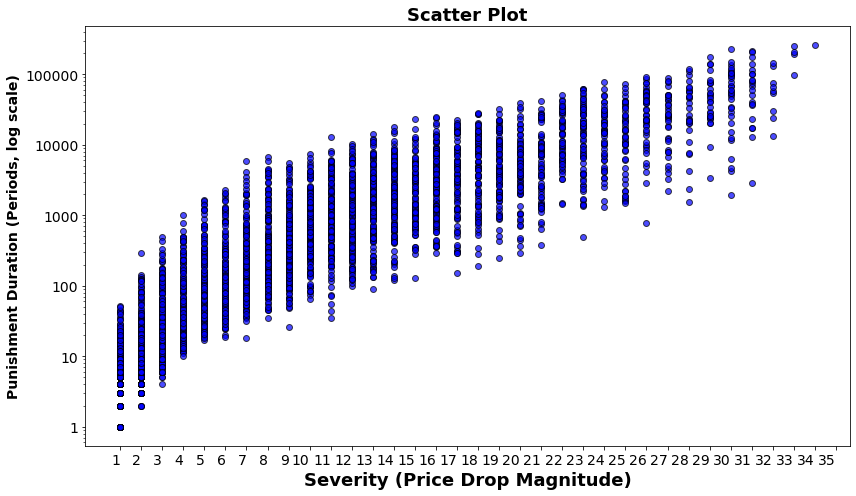

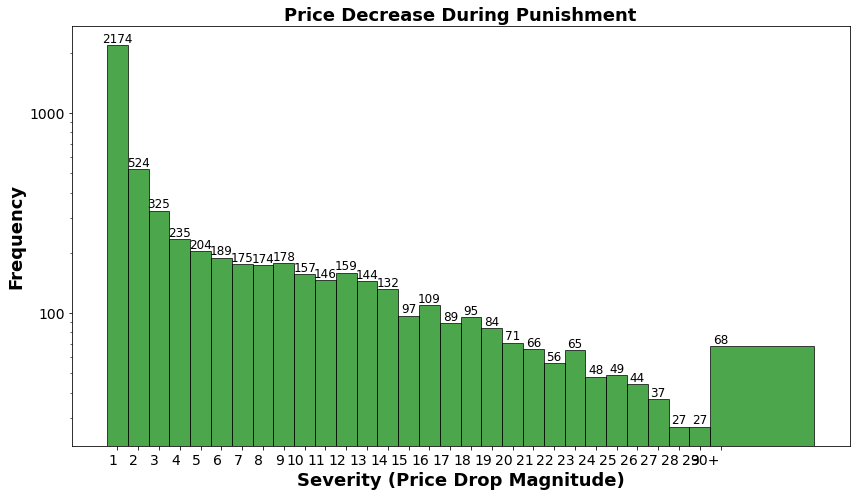

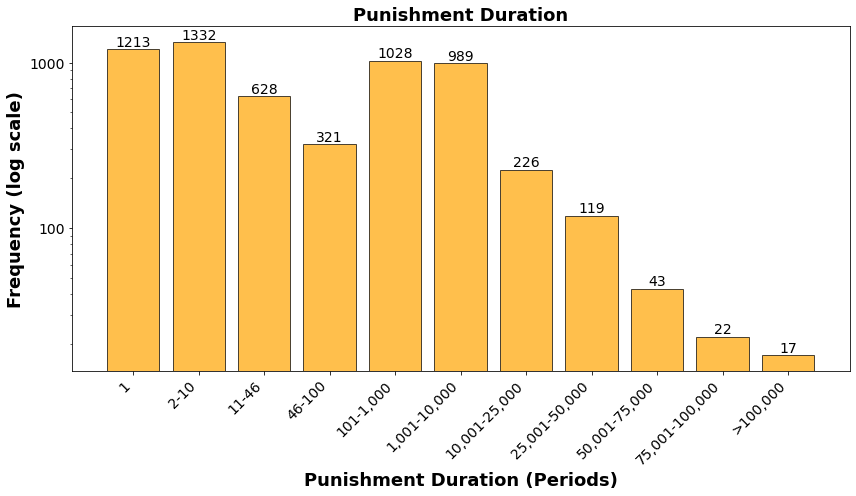

In [204]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, LogFormatter


# ---- Scatter Plot: Severity vs. Punishment Duration ----
fig1 = plt.figure(figsize=(12, 7))
ax1 = fig1.add_subplot(111)
ax1.scatter(df_all_price_wars['Price Drop'], df_all_price_wars['Iterations Until Recovery'], 
            color='blue', edgecolors='black', alpha=0.7)
ax1.set_xlabel("Severity (Price Drop Magnitude)", fontweight='bold', fontsize=18)
ax1.set_ylabel("Punishment Duration (Periods, log scale)", fontweight='bold', fontsize=14)
ax1.set_yscale('log')
ax1.set_title("Scatter Plot", fontsize=18, fontweight='bold')

# Customize y-axis tick labels to show normal numbers
formatter = mticker.ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)

# Ensure correct x-ticks
ax1.set_xticks(range(int(min(df_all_price_wars['Price Drop'])), 
                      int(max(df_all_price_wars['Price Drop'])) + 2, 1))
ax1.set_xticklabels(ax1.get_xticks(), ha='right', fontsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig("NEW_punishment_1.png")
plt.show()

# ---- Histogram: Severity Distribution ----
fig2 = plt.figure(figsize=(12, 7))
ax2 = fig2.add_subplot(111)

# Determine bins dynamically based on data
severity_bins = np.arange(min(df_all_price_wars['Price Drop']), 
                          max(df_all_price_wars['Price Drop']) + 2, 1)
counts, bins, patches = ax2.hist(df_all_price_wars['Price Drop'], bins=severity_bins, 
                                 color='green', edgecolor='black', alpha=0.7)

ax2.set_xlabel("Severity (Price Drop Magnitude)", fontweight='bold', fontsize=18)
ax2.set_ylabel("Frequency", fontweight='bold', fontsize=18)
ax2.set_yscale('log')
ax2.set_title("Price Decrease During Punishment", fontsize=18, fontweight='bold')

# Add counts on top of bars
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        ax2.text(bin_edge + 0.5, count + 0.1, f"{int(count)}", 
                 ha='center', va='bottom', fontsize=12)

ax2.set_xticks(bins[:-1] + 0.5)
ax2.set_xticklabels([str(int(b)) for b in bins[:-1]], ha='right', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)

# Force normal numbering on the y-axis (disable scientific notation)
ax2.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.yaxis.get_major_formatter().set_scientific(False)
ax2.yaxis.get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.savefig("NEW_punishment_2.png")
plt.show()

# ---- Histogram: Punishment Duration ----
fig3 = plt.figure(figsize=(12, 7))

# Custom bin ranges for punishment duration
bins_custom = [0, 2, 11, 46, 100, 1000, 10000, 25000, 50000, 75000, 100000, max(df_results['Iterations Until Recovery'])]
bin_labels = ["1", "2-10", "11-46", "46-100", "101-1,000", 
              "1,001-10,000", "10,001-25,000", "25,001-50,000", 
              "50,001-75,000", "75,001-100,000", ">100,000"]

binned_counts = [np.sum((df_all_price_wars['Iterations Until Recovery'] >= bins_custom[i]) & 
                        (df_all_price_wars['Iterations Until Recovery'] < bins_custom[i+1])) 
                 for i in range(len(bins_custom)-1)]

ax3 = fig3.add_subplot(111)
ax3.bar(bin_labels, binned_counts, color='orange', edgecolor='black', alpha=0.7)

# Customize x-axis labels
ax3.set_xticks(range(len(bin_labels)))
ax3.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=14)

ax3.set_yscale('log')
ax3.set_xlabel("Punishment Duration (Periods)", fontweight='bold', fontsize=18)
ax3.set_ylabel("Frequency (log scale)", fontweight='bold', fontsize=18)
ax3.set_title("Punishment Duration", fontsize=18, fontweight='bold')

ax3.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
ax3.yaxis.set_major_formatter(LogFormatter(base=10.0))

ax3.tick_params(axis='y', labelsize=14)

# Add counts on top of bars
for i, count in enumerate(binned_counts):
    if count > 0:
        ax3.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=14)
        
ax3.yaxis.set_major_locator(LogLocator(base=10.0))  # Set ticks at powers of 10
ax3.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax3.yaxis.get_major_formatter().set_scientific(False)  # Disable scientific notation
ax3.yaxis.get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.savefig("NEW_punishment_3.png")
plt.show()


Variance testing

In [52]:
prices, Final_Policy = simulate_bertrand_rl(n_players=2, max_iterations= 500000, price_floor=10, price_cap=55, start_prices=10)

moving_avg_A = pd.Series(prices[0]).rolling(window=window_size).mean()
moving_avg_B = pd.Series(prices[1]).rolling(window=window_size).mean()

#plot_price_development(prices, window = 1000)
A_levene = prices[0]
B_levene = prices[1]
# Subtract moving average to get residuals
A_residuals = A_levene - moving_avg_A
B_residuals = B_levene - moving_avg_B

# Drop NaN values introduced by rolling window
A_residuals = A_residuals[~np.isnan(A_residuals)]
B_residuals = B_residuals[~np.isnan(B_residuals)]

# Find the first occurrence of 35 in original data
split_index_a = next((i for i, x in enumerate(A_levene) if x >= 35), None)
split_index_b = next((i for i, x in enumerate(B_levene) if x >= 35), None)

if split_index_a is not None and split_index_b is not None:
    # Split the residuals into two groups
    firm_a_group1 = A_residuals[:split_index_a + 1]
    firm_a_group2 = A_residuals[split_index_a + 1:]
    firm_b_group1 = B_residuals[:split_index_b + 1]
    firm_b_group2 = B_residuals[split_index_b + 1:]
    
    var_a1, var_a2 = np.var(firm_a_group1, ddof=1), np.var(firm_a_group2, ddof=1)
    var_b1, var_b2 = np.var(firm_b_group1, ddof=1), np.var(firm_b_group2, ddof=1)

    # Determine direction of change
    direction_a = "Increased" if var_a2 > var_a1 else "Decreased"
    direction_b = "Increased" if var_b2 > var_b1 else "Decreased"

    # Perform Levene's test
    stat_a, p_value_a = levene(firm_a_group1, firm_a_group2)
    stat_b, p_value_b = levene(firm_b_group1, firm_b_group2)

    # Generate LaTeX Table
    latex_table = f"""
    \\begin{{table}}[h!]
    \\centering
    \\begin{{tabular}}{{|l|c|c|}}
    \\hline
    \\textbf{{Metric}} & \\textbf{{Firm A}} & \\textbf{{Firm B}} \\\\ \\hline
    Variance (Group 1) & {var_a1:.4f} & {var_b1:.4f} \\\\ \\hline
    Variance (Group 2) & {var_a2:.4f} & {var_b2:.4f} \\\\ \\hline
    Direction of Change & {direction_a} & {direction_b} \\\\ \\hline
    Levene's Test Statistic & {stat_a:.4f} & {stat_b:.4f} \\\\ \\hline
    p-value & {p_value_a:.4f} & {p_value_b:.4f} \\\\ \\hline
    Conclusion & {"Significant" if p_value_a < 0.05 else "Not Significant"} & {"Significant" if p_value_b < 0.05 else "Not Significant"} \\\\ \\hline
    \\end{{tabular}}
    \\caption{{Results of Levene's test for variance comparison after removing trend for Firms A and B.}}
    \\label{{tab:levene_moving_avg}}
    \\end{{table}}
    """

    print(latex_table)
else:
    print("Threshold value 35 not found in the data for one or both firms.")



    \begin{table}[h!]
    \centering
    \begin{tabular}{|l|c|c|}
    \hline
    \textbf{Metric} & \textbf{Firm A} & \textbf{Firm B} \\ \hline
    Variance (Group 1) & 5.5509 & 5.5615 \\ \hline
    Variance (Group 2) & 16.1963 & 16.5092 \\ \hline
    Direction of Change & Increased & Increased \\ \hline
    Levene's Test Statistic & 20529.0895 & 21428.8988 \\ \hline
    p-value & 0.0000 & 0.0000 \\ \hline
    Conclusion & Significant & Significant \\ \hline
    \end{tabular}
    \caption{Results of Levene's test for variance comparison after removing trend for Firms A and B.}
    \label{tab:levene_moving_avg}
    \end{table}
    


Adjusted algorithm to allow for different marginal costs

In [63]:
def simulate_bertrand_rl_diffmc(n_players=2, max_iterations=500000, price_floor=10, price_cap=55, start_prices=10, mc_list=None):
    # Check if mc_list is provided and has the correct length
    if mc_list is None:
        mc_list = [10] * n_players  # Default to all firms having mc=10 if not provided
    elif len(mc_list) != n_players:
        raise ValueError("Length of mc_list must match n_players")
    
    # Initialize firms with different marginal costs
    firms = [Firm_N(mc=mc, price_floor=price_floor, price_cap=price_cap) for mc in mc_list]

    if isinstance(start_prices, (int, float)):
        prices = [start_prices] * n_players
    elif isinstance(start_prices, list):
        if len(start_prices) != n_players:
            raise ValueError("Length of start_prices must match n_players")
        prices = start_prices
    else:
        raise ValueError("start_prices must be an int, float, or list of length n_players")

    price_histories = [[p] for p in prices]
    rewards = [[] for _ in range(n_players)]
    Final_policy = []

    for _ in range(max_iterations):
        states = [firm.get_state(prices) for firm in firms]
        actions = [firm.get_action(state, prices, j) for j, (firm, state) in enumerate(zip(firms, states))]

        # Determine new prices
        new_prices = []
        for j, (firm, action) in enumerate(zip(firms, actions)):
            if action == 0:  # Decrease price
                new_price = max(prices[j] - 1, price_floor)
            elif action == 2:  # Increase price
                new_price = min(prices[j] + 1, price_cap)
            else:
                new_price = prices[j]
            new_prices.append(new_price)

        # Find the minimum price and the number of firms setting it
        min_price = min(new_prices)
        min_price_n = new_prices.count(min_price)

        # Compute profit ONCE (only firms with min_price get this)
        profit_value = (100 - min_price) * (min_price - 10) / min_price_n

        # Assign profits (only firms setting min_price receive profit_value)
        profits = [profit_value if new_prices[j] == min_price else 0 for j in range(n_players)]

        # Update Q-values
        for j, firm in enumerate(firms):
            next_state = firm.get_state(new_prices)
            firm.update_q_value(states[j], actions[j], profits[j], next_state)

        # Store results
        for j in range(n_players):
            price_histories[j].append(new_prices[j])
            rewards[j].append(profits[j])

        prices = new_prices

    for firm in firms:
        Final_policy.append(firm.get_learned_policy())

    return price_histories, Final_policy


Price war data for different marginal costs

In [212]:
#pricesDiffMC, _ = simulate_bertrand_rl_diffmc(n_players=2, max_iterations= 500000, price_floor=10, price_cap=55, start_prices=20,mc_list=[10,20])

#df_diffmc, _ = analyze_price_wars(pricesDiffMC)

# Number of simulations to run
num_simulations = 50
n_players = 2
max_iterations = 500000
start_prices = 10
# Data storage
all_price_diff = []
simultaneous_war_diff = []

for i in range(num_simulations):
    # Run simulation
    pricesDiffMC, _ = simulate_bertrand_rl_diffmc(n_players=2, max_iterations= 500000, price_floor=10, price_cap=55, start_prices=20,mc_list=[10,20])
    last_price.append(pricesDiffMC[1][-1])
    # Analyse price wars
    df_wars, simultaneous_wars = analyze_price_wars(pricesDiffMC)
    
    # Add simulation number for tracking
    df_wars["Simulation"] = i + 1
    all_price_diff.append(df_wars)
    simultaneous_war_diff.append(simultaneous_wars)

# Combine all simulation results into one DataFrame
df_all_price_diff = pd.concat(all_price_diff, ignore_index=True)

# Convert simultaneous price war counts to a DataFrame
df_simultaneous_diff = pd.DataFrame({"Simulation": range(1, num_simulations + 1), 
                                        "Simultaneous Price Wars": simultaneous_war_diff})

# Print summary statistics
print("Unilateral Price War Summary:")
print(df_all_price_diff.describe())

print("\nSimultaneous Price War Summary:")
print(df_simultaneous_diff.describe())

# Save results
df_all_price_diff.to_csv("unilateral_price_diff.csv", index=False)
df_simultaneous_diff.to_csv("simultaneous_price_diff.csv", index=False)


Unilateral Price War Summary:
       Firm Initiated  Iterations Until Recovery  Starting Price   Price Drop  \
count     4661.000000                4661.000000     4661.000000  4661.000000   
mean         0.496031                4275.729028       32.711864     8.261317   
std          0.500038               14417.520792        9.460966     8.112986   
min          0.000000                   1.000000       13.000000     1.000000   
25%          0.000000                   2.000000       25.000000     1.000000   
50%          0.000000                  49.000000       32.000000     5.000000   
75%          1.000000                1586.000000       40.000000    13.000000   
max          1.000000              210785.000000       55.000000    34.000000   

       Restoration Iteration   Simulation  
count            4661.000000  4661.000000  
mean           105544.578631    25.144819  
std            107055.085961    14.554657  
min                 2.000000     1.000000  
25%             2598

Mean of last prices with different marginal costs

In [231]:
last_price = []
num_simulations = 30
for i in range(num_simulations):
    pricesDiffMC, _ = simulate_bertrand_rl_diffmc(n_players=2, max_iterations= 300000, price_floor=10, price_cap=55, start_prices=20,mc_list=[10,20])
    last_price.append(float((pricesDiffMC[1][-1] + pricesDiffMC[0][-1]) / 2))
print(sum(last_price)/len(last_price))

35.333333333333336


Statistical analysis of punishment with different marginal costs

In [214]:
# Ensure the dataset has a column for Firm (assuming column 'Firm' exists)
df_firm0 = df_all_price_diff[df_all_price_diff["Firm Initiated"] == 0]
df_firm1 = df_all_price_diff[df_all_price_diff["Firm Initiated"] == 1]

# Compute descriptive statistics for Firm 0 (lower marginal cost)
print("Descriptive Statistics for Firm A (Lower Marginal Cost):")
print(df_firm0.describe())

# Compute descriptive statistics for Firm 1 (higher marginal cost)
print("\nDescriptive Statistics for Firm B (Higher Marginal Cost):")
print(df_firm1.describe())


Descriptive Statistics for Firm 0 (Lower Marginal Cost):
       Firm Initiated  Iterations Until Recovery  Starting Price   Price Drop  \
count          2349.0                2349.000000     2349.000000  2349.000000   
mean              0.0                4533.264794       32.529161     8.294168   
std               0.0               15370.466399        9.456600     8.226503   
min               0.0                   1.000000       14.000000     1.000000   
25%               0.0                   2.000000       25.000000     1.000000   
50%               0.0                  48.000000       32.000000     5.000000   
75%               0.0                1667.000000       40.000000    13.000000   
max               0.0              183983.000000       55.000000    34.000000   

       Restoration Iteration   Simulation  
count            2349.000000  2349.000000  
mean           104984.980843    25.169434  
std            107513.593848    14.567451  
min                 4.000000     1.00

In [228]:
import scipy.stats as stats
import numpy as np

# Extract data for Price Drop
drop_diff = df_all_price_diff["Price Drop"]
drop_same = df_all_price_wars["Price Drop"]

# Compute standard errors
se_recovery_diff = recovery_diff.std() / np.sqrt(len(recovery_diff))
se_recovery_same = recovery_same.std() / np.sqrt(len(recovery_same))
se_drop_diff = drop_diff.std() / np.sqrt(len(drop_diff))
se_drop_same = drop_same.std() / np.sqrt(len(drop_same))

# Conduct t-tests
t_recovery, p_recovery = stats.ttest_ind(recovery_diff, recovery_same, equal_var=False)
t_drop, p_drop = stats.ttest_ind(drop_diff, drop_same, equal_var=False)

# Generate LaTeX table
latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\begin{{tabular}}{{|l|c|c|}}
        \\hline
        & \\textbf{{Iterations Until Recovery}} & \\textbf{{Price Drop}} \\\\
        \\hline
        \\textbf{{Asymmetric Cost (Mean ± SE)}} & $ {recovery_diff.mean():.2f} \\pm {se_recovery_diff:.2f} $ & $ {drop_diff.mean():.2f} \\pm {se_drop_diff:.2f} $ \\\\
        \\hline
        \\textbf{{Symmetric Cost (Mean ± SE)}} & $ {recovery_same.mean():.2f} \\pm {se_recovery_same:.2f} $ & $ {drop_same.mean():.2f} \\pm {se_drop_same:.2f} $ \\\\
        \\hline
        \\textbf{{p-value}} & $ {p_recovery:.4f} $ & $ {p_drop:.4f} $ \\\\
        \\hline
    \\end{{tabular}}
    \\caption{{Comparison of Cartel Breaking Punishment Metrics for Asymmetric and Symmetric Marginal Costs (Mean ± Standard Error)}}
    \\label{{tab:cartel_punishment_comparison}}
\\end{{table}}
"""

# Print LaTeX table for copy-pasting
print(latex_table)


\begin{table}[h]
    \centering
    \begin{tabular}{|l|c|c|}
        \hline
        & \textbf{Iterations Until Recovery} & \textbf{Price Drop} \\
        \hline
        \textbf{Asymmetric Cost (Mean ± SE)} & $ 4275.73 \pm 211.18 $ & $ 8.26 \pm 0.12 $ \\
        \hline
        \textbf{Symmetric Cost (Mean ± SE)} & $ 3419.54 \pm 180.66 $ & $ 7.06 \pm 0.10 $ \\
        \hline
        \textbf{p-value} & $ 0.0021 $ & $ 0.0000 $ \\
        \hline
    \end{tabular}
    \caption{Comparison of Cartel Breaking Punishment Metrics for Asymmetric and Symmetric Marginal Costs (Mean ± Standard Error)}
    \label{tab:cartel_punishment_comparison}
\end{table}



In [180]:
pricesDiffMC, _ = simulate_bertrand_rl_diffmc(n_players=2, max_iterations= 500000, price_floor=19, price_cap=55, start_prices=20,mc_list=[10,20])

Visualisation for different marginal costs

33.68953864487122


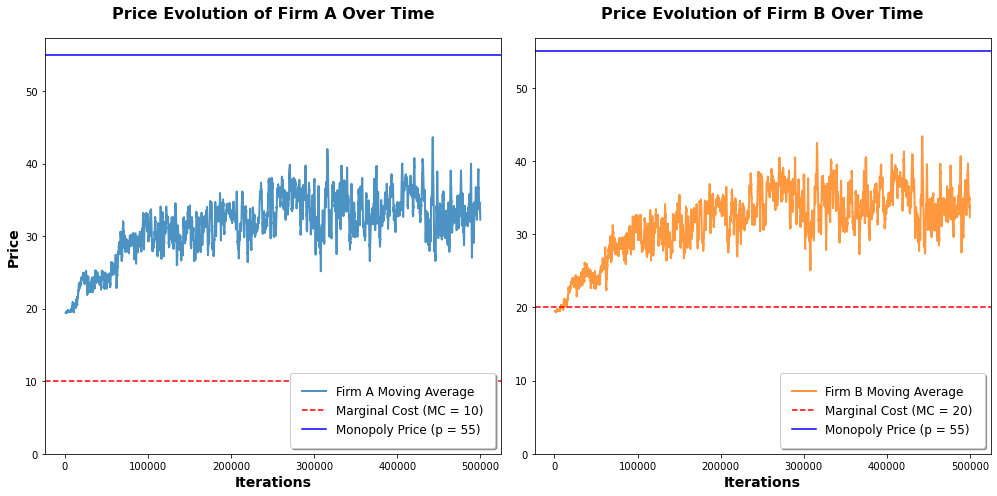

In [183]:
window_size = 1000
moving_avg_A = pd.Series(pricesDiffMC[0]).rolling(window=window_size).mean()
moving_avg_B = pd.Series(pricesDiffMC[1]).rolling(window=window_size).mean()
mean_stable =  moving_avg_A[200000:].mean()
print(mean_stable)
# Define figure and subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# Firm A Plot
ax1.plot(moving_avg_A, label='Firm A Moving Average', color='#1f77b4', linewidth=2, alpha=0.8)
ax1.axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 10)')
ax1.axhline(y=55, color='blue', linestyle='-', linewidth=1.5, label='Monopoly Price (p = 55)')
ax1.set_xlabel('Iterations', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price', fontsize=14, fontweight='bold')
ax1.set_title('Price Evolution of Firm A Over Time', fontsize=16, fontweight='bold', pad=20)
ax1.ticklabel_format(style='plain', axis='x')
ax1.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1)
ax1.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0
# Firm B Plot
ax2.plot(moving_avg_B, label='Firm B Moving Average', color='#ff7f0e', linewidth=2, alpha=0.8)
ax2.axhline(y=20, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 20)')
ax2.axhline(y=55, color='blue', linestyle='-', linewidth=1.5, label='Monopoly Price (p = 55)')
ax2.set_xlabel('Iterations', fontsize=14, fontweight='bold')
ax2.set_title('Price Evolution of Firm B Over Time', fontsize=16, fontweight='bold', pad=20)
ax2.ticklabel_format(style='plain', axis='x')
ax2.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True, borderpad=1)
ax2.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0
# Save the figure
plt.tight_layout()
plt.savefig('NEW_diffmc_findings.png', format='png', dpi=300)
plt.show()



In [79]:
stats_A = {
    "Count": len(drop_magnitudes_A),
    "Mean": np.mean(drop_magnitudes_A),
    "Median": np.median(drop_magnitudes_A),
    "Standard Deviation": np.std(drop_magnitudes_A),
    "Min": np.min(drop_magnitudes_A),
    "Max": np.max(drop_magnitudes_A),
    "25th Percentile": np.percentile(drop_magnitudes_A, 25),
    "50th Percentile": np.percentile(drop_magnitudes_A, 50),
    "75th Percentile": np.percentile(drop_magnitudes_A, 75)
}

stats_B = {
    "Count": len(drop_magnitudes_B),
    "Mean": np.mean(drop_magnitudes_B),
    "Median": np.median(drop_magnitudes_B),
    "Standard Deviation": np.std(drop_magnitudes_B),
    "Min": np.min(drop_magnitudes_B),
    "Max": np.max(drop_magnitudes_B),
    "25th Percentile": np.percentile(drop_magnitudes_B, 25),
    "50th Percentile": np.percentile(drop_magnitudes_B, 50),
    "75th Percentile": np.percentile(drop_magnitudes_B, 75)
}
print(stats_A)
print(stats_B)


{'Count': 11556, 'Mean': 2.5334025614399445, 'Median': 1.0, 'Standard Deviation': 2.998760944817204, 'Min': 1, 'Max': 29, '25th Percentile': 1.0, '50th Percentile': 1.0, '75th Percentile': 3.0}
{'Count': 14021, 'Mean': 2.237786177876043, 'Median': 1.0, 'Standard Deviation': 2.695692582018971, 'Min': 1, 'Max': 28, '25th Percentile': 1.0, '50th Percentile': 1.0, '75th Percentile': 2.0}


Different Demand functions

In [81]:
def simulate_bertrand_root(n_players=2, max_iterations=500000, price_floor=10, price_cap=55, start_prices=10):
    firms = [Firm_N(mc=10, price_floor=price_floor, price_cap=price_cap) for _ in range(n_players)]

    if isinstance(start_prices, (int, float)):
        prices = [start_prices] * n_players
    elif isinstance(start_prices, list):
        if len(start_prices) != n_players:
            raise ValueError("Length of start_prices must match n_players")
        prices = start_prices
    else:
        raise ValueError("start_prices must be an int, float, or list of length n_players")

    price_histories = [[p] for p in prices]
    rewards = [[] for _ in range(n_players)]
    Final_policy =[]

    for _ in range(max_iterations):
        states = [firm.get_state(prices) for firm in firms]
        actions = [firm.get_action(state, prices, j) for j, (firm, state) in enumerate(zip(firms, states))]

        # Determine new prices
        new_prices = []
        for j, (firm, action) in enumerate(zip(firms, actions)):
            if action == 0:  # Decrease price
                new_price = max(prices[j] - 1, price_floor)
            elif action == 2:  # Increase price
                new_price = min(prices[j] + 1, price_cap)
            else:
                new_price = prices[j]
            new_prices.append(new_price)

        # Find the minimum price and the number of firms setting it
        min_price = min(new_prices)
        min_price_n = new_prices.count(min_price)
        term1 = 90
        term2 =float( (880 + 620 * math.sqrt(22)) / 97)
        term3 = float((4 * (22 * math.sqrt(10) + 31 * math.sqrt(55))) / 97 * math.sqrt(min_price))
        x = round(float(term1 + term2 - term3))

        # Compute profit ONCE (only firms with min_price get this)
        profit_value = (x - min_price) * (min_price - 10) / min_price_n

        # Assign profits (only firms setting min_price receive profit_value)
        profits = [profit_value if new_prices[j] == min_price else 0 for j in range(n_players)]

        # Update Q-values
        for j, firm in enumerate(firms):
            next_state = firm.get_state(new_prices)
            firm.update_q_value(states[j], actions[j], profits[j], next_state)

        # Store results
        for j in range(n_players):
            price_histories[j].append(new_prices[j])
            rewards[j].append(profits[j])

        prices = new_prices
        

    for firm in firms:
        Final_policy.append(firm.get_learned_policy())

    return price_histories, Final_policy

In [95]:
def simulate_bertrand_square(n_players=2, max_iterations=500000, price_floor=10, price_cap=55, start_prices=10):
    firms = [Firm_N(mc=10, price_floor=price_floor, price_cap=price_cap) for _ in range(n_players)]

    if isinstance(start_prices, (int, float)):
        prices = [start_prices] * n_players
    elif isinstance(start_prices, list):
        if len(start_prices) != n_players:
            raise ValueError("Length of start_prices must match n_players")
        prices = start_prices
    else:
        raise ValueError("start_prices must be an int, float, or list of length n_players")

    price_histories = [[p] for p in prices]
    rewards = [[] for _ in range(n_players)]
    Final_policy =[]

    for _ in range(max_iterations):
        states = [firm.get_state(prices) for firm in firms]
        actions = [firm.get_action(state, prices, j) for j, (firm, state) in enumerate(zip(firms, states))]

        # Determine new prices
        new_prices = []
        for j, (firm, action) in enumerate(zip(firms, actions)):
            if action == 0:  # Decrease price
                new_price = max(prices[j] - 1, price_floor)
            elif action == 2:  # Increase price
                new_price = min(prices[j] + 1, price_cap)
            else:
                new_price = prices[j]
            new_prices.append(new_price)

        # Find the minimum price and the number of firms setting it
        min_price = min(new_prices)
        min_price_n = new_prices.count(min_price)
        x = float(float(638/7)-(2/175)*min_price*min_price)

        # Compute profit ONCE (only firms with min_price get this)
        profit_value = (x - min_price) * (min_price - 10) / min_price_n

        # Assign profits (only firms setting min_price receive profit_value)
        profits = [profit_value if new_prices[j] == min_price else 0 for j in range(n_players)]

        # Update Q-values
        for j, firm in enumerate(firms):
            next_state = firm.get_state(new_prices)
            firm.update_q_value(states[j], actions[j], profits[j], next_state)

        # Store results
        for j in range(n_players):
            price_histories[j].append(new_prices[j])
            rewards[j].append(profits[j])

        prices = new_prices
        

    for firm in firms:
        Final_policy.append(firm.get_learned_policy())

    return price_histories, Final_policy

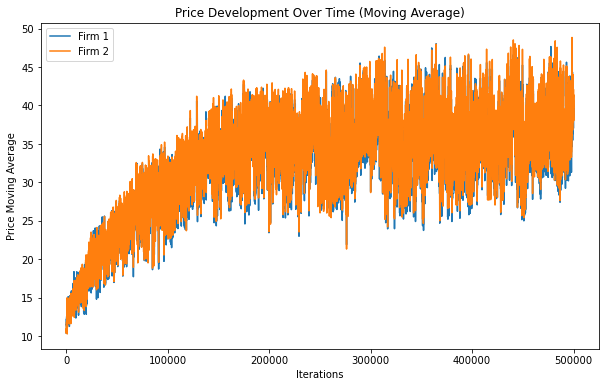

In [93]:
price_histories_root, _ = simulate_bertrand_root(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
#price_histories_root = price_histories_root[0]
plot_price_development(price_histories_root)

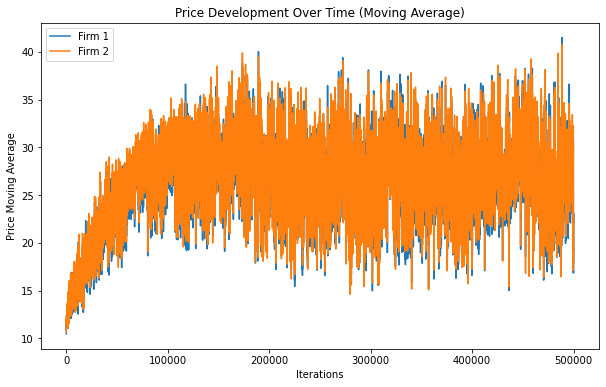

In [97]:
price_histories_square = simulate_bertrand_square(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
price_histories_square = price_histories_square[0]
plot_price_development(price_histories_square, window=50)

In [205]:
final_prices_root = []
final_prices_square = []
for i in range(50):
    # Simulate one run
    pricesR, Final_Policy = simulate_bertrand_root(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
    pricesS, Final_Policy = simulate_bertrand_square(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
    if isinstance(Final_Policy, list) and len(Final_Policy) > 0:
        policy_A = Final_Policy[0]  # Extract Firm A's policy
    else:
        raise ValueError("Final_Policy does not contain expected values.")

    final_prices_root.append(prices[0][-1])
    final_prices_square.append(prices[0][-1])



# Final lists to store the prices
final_prices_root = []
final_prices_square = []

for i in range(50):
    # Simulate one run
    pricesR, Final_Policy = simulate_bertrand_root(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
    pricesS, Final_Policy = simulate_bertrand_square(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
    
    if isinstance(Final_Policy, list) and len(Final_Policy) > 0:
        policy_A = Final_Policy[0]  # Extract Firm A's policy
    else:
        raise ValueError("Final_Policy does not contain expected values.")
    
    final_prices_root.append(pricesR[0][-1])  # Append the final price for Firm A from root policy
    final_prices_square.append(pricesS[0][-1])  # Append the final price for Firm A from square policy

# Write to CSV
with open('NEWfinal_prices_diff_func.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for price_root, price_square in zip(final_prices_root, final_prices_square):
        writer.writerow([price_root, price_square])  # Write rows of data

In [208]:
# Load data
baseline_prices_new = pd.read_csv("new_final_prices.csv", header=None, skiprows=1).squeeze().astype(float)
diff_func_prices_new = pd.read_csv("NEWfinal_prices_diff_func.csv", header=None, skiprows=1).astype(float)

# Extract datasets
linear_demand = baseline_prices_new
root_demand = diff_func_prices_new.iloc[0]
square_demand = diff_func_prices_new.iloc[1]

# Perform t-tests (extract only p-values)
t_test_pvalues = {
    "Linear vs Root": round(ttest_ind(linear_demand, root_demand, equal_var=False)[1], 4),
    "Linear vs Square": round(ttest_ind(linear_demand, square_demand, equal_var=False)[1], 4),
    "Root vs Square": round(ttest_ind(root_demand, square_demand, equal_var=False)[1], 4),
}

# Create a DataFrame for the comparisons and p-values
t_test_results = pd.DataFrame(
    list(t_test_pvalues.items()), columns=["Comparison", "p-value"]
)

# Display result in LaTeX format
latex_table = t_test_results.to_latex(index=False, float_format="%.4f", escape=False)
print(latex_table)

\begin{tabular}{lr}
\toprule
       Comparison &  p-value \\
\midrule
   Linear vs Root &   0.5196 \\
 Linear vs Square &   0.8553 \\
   Root vs Square &   0.7076 \\
\bottomrule
\end{tabular}



In [161]:
price_histories_root, _ = simulate_bertrand_root(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
price_histories_square, _ = simulate_bertrand_square(n_players=2, max_iterations=300000, price_floor=10, price_cap=55, start_prices=10)
price_histories_root = price_histories_root[0]
price_histories_square = price_histories_square[0]

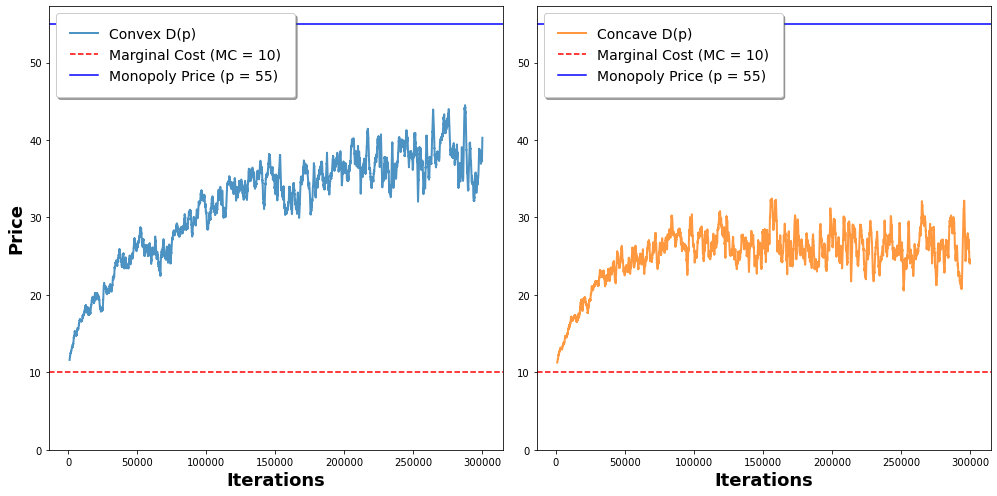

In [162]:
window_size = 1000
moving_avg_A = pd.Series(price_histories_root).rolling(window=window_size).mean()
moving_avg_B = pd.Series(price_histories_square).rolling(window=window_size).mean()

# Define figure and subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# Firm A Plot
ax1.plot(moving_avg_A, label='Convex D(p)', color='#1f77b4', linewidth=2, alpha=0.8)
ax1.axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 10)')
ax1.axhline(y=55, color='blue', linestyle='-', linewidth=1.5, label='Monopoly Price (p = 55)')
ax1.set_xlabel('Iterations', fontsize=18, fontweight='bold')
ax1.set_ylabel('Price', fontsize=18, fontweight='bold')
ax1.ticklabel_format(style='plain', axis='x')
ax1.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True, borderpad=1)
ax1.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0
# Firm B Plot
ax2.plot(moving_avg_B, label='Concave D(p)', color='#ff7f0e', linewidth=2, alpha=0.8)
ax2.axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 10)')
ax2.axhline(y=55, color='blue', linestyle='-', linewidth=1.5, label='Monopoly Price (p = 55)')
ax2.set_xlabel('Iterations', fontsize=18, fontweight='bold')
ax2.ticklabel_format(style='plain', axis='x')
ax2.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True, borderpad=1)
ax2.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0
# Save the figure
plt.tight_layout()
plt.savefig('NEW_diff_dp.png', format='png', dpi=300)
plt.show()

N firms visualisation

In [165]:
price4n, _ = simulate_bertrand_rl(4, 5000000, 10, 55, 10)
price3n, _ = simulate_bertrand_rl(3, 5000000, 10, 55, 10)
price2n, _ = simulate_bertrand_rl(2, 300000, 10, 55, 10)

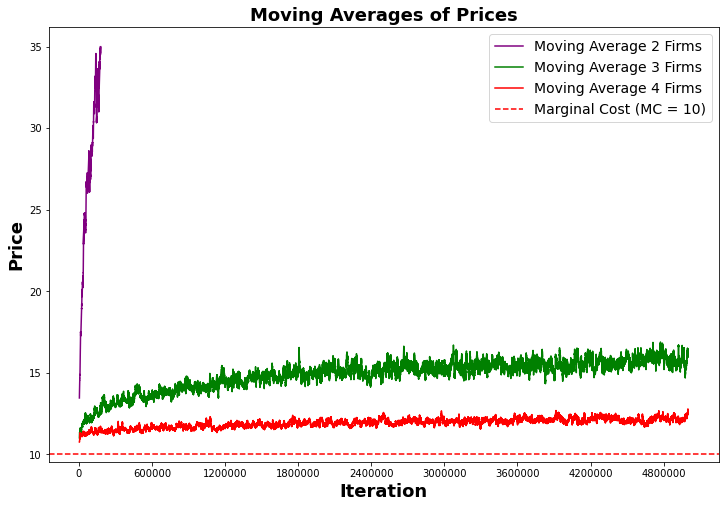

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Extract prices
price2a = price2n[0]
price3a = price3n[0]
price4a = price4n[0]

# Compute moving averages

moving_avg_4 = pd.Series(price4a).rolling(window=5000).mean()
moving_avg_3 = pd.Series(price3a).rolling(window=5000).mean()
moving_avg_2 = pd.Series(price2a).rolling(window=5000).mean()

# Function to trim moving averages once they reach 35
def trim_moving_avg(moving_avg):
    return moving_avg[: (moving_avg >= 35).idxmax()] if (moving_avg >= 35).any() else moving_avg

# Trim each moving average separately
moving_avg_5 = trim_moving_avg(moving_avg_5)
moving_avg_4 = trim_moving_avg(moving_avg_4)
moving_avg_3 = trim_moving_avg(moving_avg_3)
moving_avg_2 = trim_moving_avg(moving_avg_2)

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot only up to the stopping point for each series
ax.plot(moving_avg_2, '-', label="Moving Average 2 Firms", color="purple")
ax.plot(moving_avg_3, '-', label="Moving Average 3 Firms", color="green")
ax.plot(moving_avg_4, '-', label="Moving Average 4 Firms", color="red")
ax.axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Marginal Cost (MC = 10)')

# Set title, labels, and legend with bold font and fontsize 18
ax.set_title("Moving Averages of Prices", fontweight='bold', fontsize=18)
ax.set_xlabel("Iteration", fontweight='bold', fontsize=18)
ax.set_ylabel("Price", fontweight='bold', fontsize=18)
ax.legend(fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# Customize grid and format
ax.grid(False)
ax.ticklabel_format(style='plain', axis='x')

# Save and show the plot
plt.savefig("NEWcombined_convergence.png", format="png", bbox_inches="tight")
plt.show()
